# 🤗 HuggingFace Neural Network Notebook - Train Test Split

## Version History

### 1.0
Copied from CV Split training notebook.

## Setup

### Environment Variables

In [1]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Import Libraries

In [2]:
import os
import random
from typing import Tuple, List
import warnings
import pickle as pkl

from dotenv import load_dotenv
import wandb
from tqdm import tqdm
import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from datasets import Dataset
from tokenizers import AddedToken
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
)

In [3]:
os.chdir("../../")
warnings.simplefilter('ignore')
load_dotenv()

True

In [4]:
from lib.criterion.metrics import log_metrics
from lib.utils.find_threshold import find_thresholds

### Paths

In [5]:
class Paths:
    # Competition data with added topic column
    train_csv: str = "data/processed/train.csv"
    test_csv: str = "data/processed/test.csv"

    # Output path
    output_path: str = "output/model_dir"
    model_path: str = os.path.join(output_path, "{model_name}")
    tokenizer_path: str =  os.path.join(output_path, "{model_name}_tokenizer")
    threshold_path: str = os.path.join(output_path, "threshold.pkl")
    logging_path: str = os.path.join(output_path, "logging")

### Configurations

In [6]:
DEBUG = False
DO_SLIDING_WINDOW = True
DO_REGRESSION = True

In [7]:
class CFG:
    backbone_model: str = "microsoft/deberta-v3-xsmall"
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    lr: float = 2e-5
    lr_scheduler_type: str = "cosine"
    max_length: int = 512
    n_splits: int = 7
    num_labels: int = 6
    num_epochs: int = 3
    num_workers: int = 6
    seed: int = 20
    stride_length: int = 384
    train_batch_size: int = 32
    valid_batch_size: int = 32
    weight_decay: float = 0.01
    warmup_ratio: float = 0

In [8]:
if DEBUG:
    CFG.num_epochs = 1

In [9]:
MODEL_NAME = CFG.backbone_model.split("/")[-1]

### Setting Random Seed

In [10]:
def seed_everything() -> None:
    """Seed everything to ensure reproducibility

    Sources:
    1. https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train
    2. https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
    """
    random.seed(CFG.seed)
    os.environ["PYTHONHASHCFG.SEED"] = str(CFG.seed)
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

### WandB setup

In [11]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
type = "R" if DO_REGRESSION else "C"
WANDB_NAME = f"{MODEL_NAME}-{CFG.max_length}-{type}-TVTS"

In [12]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## Data Preparation

### Tokenizer

In [13]:
class Tokenize(object):
    def __init__(self, train, valid, test, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid
        self.test = test

    def get_dataset(self, df):
        ds = Dataset.from_dict(
            {
                "essay_id": [e for e in df["essay_id"]],
                "full_text": [ft for ft in df["full_text"]],
                "label": [s for s in df["label"]],
            }
        )
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example["full_text"],
            truncation=True,
            max_length=CFG.max_length,
            padding="max_length",
            
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)
        test_ds = self.get_dataset(self.test)

        tokenized_train = train_ds.map(self.tokenize_function, batched=True)
        tokenized_valid = valid_ds.map(self.tokenize_function, batched=True)
        tokenized_test = test_ds.map(self.tokenize_function, batched=True)

        return tokenized_train, tokenized_valid, tokenized_test, self.tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(CFG.backbone_model)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])
tokenizer.save_pretrained(Paths.tokenizer_path.format(model_name=MODEL_NAME))

('output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer_config.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/special_tokens_map.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/spm.model',
 'output/model_dir/deberta-v3-xsmall_tokenizer/added_tokens.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer.json')

### Data Preprocessing

1. Convert `label` to be in `scores` which are processed to be in range $[0-5]$.
2. Convert `label` data type based on whether we are doing regression or classification.

In [15]:
data = pd.read_csv(Paths.train_csv, low_memory=False)
print("Training dataset has shape:", data.shape)

data["label"] = data["score"].map(lambda x: x- 1)

if DO_REGRESSION:
    data["label"] = data["label"].astype(pd.Float32Dtype())
else:
    data["label"] = data["label"].astype(pd.Int32Dtype())

data.head(3)

Training dataset has shape: (17307, 4)


,essay_id,full_text,score,topic,label
0,000d118,Many people have car where they live. The thin...,3,5,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0


### Train-Valid-Test Splitting

In [16]:
train_data, test_data  = train_test_split(
    data,
    test_size=0.1,
    shuffle=True,
    random_state=CFG.seed,
)
train_data, valid_data  = train_test_split(
    train_data,
    test_size=0.1,
    shuffle=True,
    random_state=CFG.seed,
)
print("Shapes of train, valid and test data:", train_data.shape, valid_data.shape, test_data.shape)

Shapes of train, valid and test data: (14018, 5) (1558, 5) (1731, 5)


### Sliding Window

Essays can have varying lengths. Instead of truncating, see the entire essay as windows of length `CFG.max_length` which are strided with `CFG.stride_length`.

In [17]:
def construct_new_row(old_row, text):
    new_row = {key: old_row[key] for key in old_row.keys() if key != "index"}
    new_row["full_text"] = text
    return new_row

In [18]:
def split_tokens(tokens, stride):
    """Splits `tokens` into multiple sequences that have at most
    `CFG.max_length` tokens. Uses `CFG.stride` for sliding
    window.

    Args:
        tokens (List): List of tokens.
        stride (int): Stride length.

    Returns:
        List[List[int]]: List of split token sequences.
    """
    start = 0
    sequence_list = []

    while start < len(tokens):
        remaining_tokens = len(tokens) - start

        if remaining_tokens < CFG.max_length and start > 0:
            start = max(0, len(tokens) - CFG.max_length)

        end = min(start + CFG.max_length, len(tokens))
        sequence_list.append(tokens[start:end])

        if remaining_tokens >= CFG.max_length:
            start += stride
        else:
            break

    return sequence_list

In [19]:
def sliding_window(df, tokenizer):
    """Splits rows of `df` so that each row's text has at most
    `CFG.max_length` number of tokens.

    Args:
        df (pd.DataFrame): Input data frame.
        tokenizer (_type_): Tokenizer used to encode and decode text.

    Returns:
        pd.DataFrame: Newly constructed dataframe.
    """

    new_df = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        tokens = tokenizer.encode(row["full_text"], add_special_tokens=False)

        if len(tokens) <= CFG.max_length:
            new_df.append(construct_new_row(row, row["full_text"]))
        else:
            sequence_list = split_tokens(tokens, CFG.stride_length)

            for seq in sequence_list:
                new_df.append(
                    construct_new_row(
                        row,
                        tokenizer.decode(seq, skip_special_tokens=True),
                    )
                )

    return pd.DataFrame(new_df)

In [20]:
if DO_SLIDING_WINDOW:
    train_data = sliding_window(train_data, tokenizer)
    valid_data = sliding_window(valid_data, tokenizer)
    test_data = sliding_window(test_data, tokenizer)
    print("Shapes of train, valid and test data:", train_data.shape, valid_data.shape, test_data.shape)

100%|██████████| 1731/1731 [00:03<00:00, 536.32it/s]

Shapes of train, valid and test data: (18420, 5) (2039, 5) (2288, 5)


## Metrics

### QWK Score Calculation

In [21]:
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.clip(0, 5).round(0),
        weights="quadratic",
    )

    return {"qwk": qwk}

In [22]:
def compute_metrics_for_classification(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.argmax(-1),
        weights="quadratic",
    )
    
    return {"qwk": qwk}

In [23]:
if DO_REGRESSION:
    compute_metrics = compute_metrics_for_regression
else:
    compute_metrics = compute_metrics_for_classification

### WandB Metric Logging

In [24]:
def plot_wandb_bar(data, label, value, id, title):
    table = wandb.Table(data=data, columns=[label, value])
    wandb.log({id: wandb.plot.bar(table, label, value, title=title)})

In [25]:
def plot_metrics(prefix, precision_data, recall_data, f1_data):
    plot_wandb_bar(
        f1_data,
        "score",
        "F1 Score",
        f"{prefix}/F1 Score",
        f"F1 score for {prefix}",
    )
    plot_wandb_bar(
        recall_data,
        "score",
        "Recall",
        f"{prefix}/Recall",
        f"Recall for {prefix}",
    )
    plot_wandb_bar(
        precision_data,
        "score",
        "Precision",
        f"{prefix}/Precision",
        f"Precision for {prefix}",
    )

In [26]:
def calcluate_metrics(df):
    precision_data = [None for _ in range(CFG.num_labels)]
    recall_data = [None for _ in range(CFG.num_labels)]
    f1_data = [None for _ in range(CFG.num_labels)]

    for label in range(CFG.num_labels):
        tp = df.loc[(df.label == label) & (df.label == df.pred_score), "label"].count()
        fp = df.loc[(df.label != label) & (df.pred_score == label), "label"].count()
        tn = df.loc[(df.label != label) & (df.pred_score != label), "label"].count()
        fn = df.loc[(df.label == label) & (df.pred_score != label), "label"].count()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)

        precision_data[label] = (label, precision)
        recall_data[label] = (label, recall)
        f1_data[label] = (label, f1)

    return precision_data, recall_data, f1_data

In [27]:
def log_metrics(df, prefix):
    wandb.log(
        {
            f"{prefix}/conf_mat": wandb.plot.confusion_matrix(
                probs=None,
                y_true=df["label"].astype(pd.Int32Dtype()),
                preds=df["pred_score"].astype(pd.Int32Dtype()),
                class_names=list(range(CFG.num_labels)),
            )
        }
    )

    precision_data, recall_data, f1_data = calcluate_metrics(df)
    plot_metrics(prefix, precision_data, recall_data, f1_data)

## Training

### Training Arguments

In [28]:
training_args = TrainingArguments(
    data_seed=CFG.seed,
    dataloader_num_workers=CFG.num_workers,
    evaluation_strategy="epoch",
    fp16=True,
    gradient_checkpointing=CFG.gradient_checkpointing,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    learning_rate=CFG.lr,
    load_best_model_at_end=True,
    logging_first_step=True,
    logging_steps=50,
    logging_dir=Paths.logging_path,
    lr_scheduler_type=CFG.lr_scheduler_type,
    metric_for_best_model="qwk",
    num_train_epochs=CFG.num_epochs,
    output_dir=Paths.output_path,
    optim="adamw_torch",
    per_device_eval_batch_size=CFG.valid_batch_size,
    per_device_train_batch_size=CFG.train_batch_size,
    report_to="wandb",
    seed=CFG.seed,
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=CFG.weight_decay,
    warmup_ratio=CFG.warmup_ratio,
)

### Utility Functions

In [36]:
def tokenize_data(
    train: pd.DataFrame,
    valid: pd.DataFrame,
    test: pd.DataFrame,
) -> Tuple[Dataset, Dataset, Dataset]:
    tokenize = Tokenize(train, valid, test, tokenizer)
    tokenized_train, tokenized_valid, tokenized_test, _ = tokenize()
    return tokenized_train, tokenized_valid, tokenized_test

In [30]:
def configure():
    config = AutoConfig.from_pretrained(CFG.backbone_model)
    
    if DO_REGRESSION:
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = CFG.num_labels

    return config

In [31]:
def get_model(config):
    backbone_model = AutoModelForSequenceClassification.from_pretrained(
        CFG.backbone_model,
        config=config,
    )
    backbone_model.resize_token_embeddings(len(tokenizer))
    return backbone_model

In [32]:
def post_process_predictions(predictions0):
    if DO_REGRESSION:
        predictions = predictions0.clip(0, 5).round(0)
    else:
        predictions = predictions0.argmax(axis=1)

    return predictions

In [33]:
def plot_confusion_matrxi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[x for x in range(CFG.num_labels)])
    draw_cm = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=[x for x in range(CFG.num_labels)]
    )
    draw_cm.plot()
    plt.show()

In [34]:
def save_predictions(fold, valid, logits, y_pred):
    if DO_REGRESSION:
        valid["logit"] = logits
    else:
        COLS = [f"p{x}" for x in range(CFG.num_labels)]
        valid[COLS] = logits

    valid["pred_score"] = y_pred
    valid.to_csv(Paths.oof_path.format(fold=fold), index=False)
    return valid

### CV Training Fold Loop

In [37]:
tokenized_train, tokenized_valid, tokenized_test = tokenize_data(
    train_data, valid_data, test_data
)

config = configure()

backbone_model = get_model(config)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=backbone_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model(Paths.model_path.format(model_name=MODEL_NAME))

Map:   0%|          | 0/18420 [00:00<?, ? examples/s]

Map:   0%|          | 0/2039 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1728 [00:00<?, ?it/s]

{'loss': 6.0583, 'grad_norm': inf, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 3.1934, 'grad_norm': 9.42684555053711, 'learning_rate': 1.996351505250257e-05, 'epoch': 0.09}
{'loss': 0.7069, 'grad_norm': 18.340200424194336, 'learning_rate': 1.984490424342974e-05, 'epoch': 0.17}
{'loss': 0.5224, 'grad_norm': 4.420222282409668, 'learning_rate': 1.9644998273343753e-05, 'epoch': 0.26}
{'loss': 0.494, 'grad_norm': 12.768682479858398, 'learning_rate': 1.93654478833411e-05, 'epoch': 0.35}
{'loss': 0.4994, 'grad_norm': 3.58284592628479, 'learning_rate': 1.9008561485307222e-05, 'epoch': 0.43}
{'loss': 0.4627, 'grad_norm': 12.704874038696289, 'learning_rate': 1.8577286100002723e-05, 'epoch': 0.52}
{'loss': 0.4586, 'grad_norm': 20.03626251220703, 'learning_rate': 1.8075183021780744e-05, 'epoch': 0.61}
{'loss': 0.3965, 'grad_norm': 14.741471290588379, 'learning_rate': 1.750639841088622e-05, 'epoch': 0.69}
{'loss': 0.4175, 'grad_norm': 7.895313262939453, 'learning_rate': 1.6875629056173674e-05, '

  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 0.5291399955749512, 'eval_qwk': 0.6887866569739853, 'eval_runtime': 6.1307, 'eval_samples_per_second': 332.587, 'eval_steps_per_second': 10.439, 'epoch': 1.0}
{'loss': 0.3804, 'grad_norm': 18.376842498779297, 'learning_rate': 1.4665796148706561e-05, 'epoch': 1.04}
{'loss': 0.382, 'grad_norm': 15.111824035644531, 'learning_rate': 1.384362459385142e-05, 'epoch': 1.13}
{'loss': 0.3779, 'grad_norm': 31.071483612060547, 'learning_rate': 1.2989713971504602e-05, 'epoch': 1.22}
{'loss': 0.3757, 'grad_norm': 21.011106491088867, 'learning_rate': 1.2111115523589651e-05, 'epoch': 1.3}
{'loss': 0.3625, 'grad_norm': 8.008086204528809, 'learning_rate': 1.1215084353916933e-05, 'epoch': 1.39}
{'loss': 0.3545, 'grad_norm': 20.303468704223633, 'learning_rate': 1.0309019518527036e-05, 'epoch': 1.48}
{'loss': 0.3289, 'grad_norm': 12.510637283325195, 'learning_rate': 9.400402927335992e-06, 'epoch': 1.56}
{'loss': 0.3403, 'grad_norm': 15.556441307067871, 'learning_rate': 8.496737561607378e-06, 

  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 0.36954185366630554, 'eval_qwk': 0.8052186018262285, 'eval_runtime': 6.038, 'eval_samples_per_second': 337.692, 'eval_steps_per_second': 10.599, 'epoch': 2.0}
{'loss': 0.3191, 'grad_norm': 4.430573463439941, 'learning_rate': 4.308998541211016e-06, 'epoch': 2.08}
{'loss': 0.2922, 'grad_norm': 3.715994119644165, 'learning_rate': 3.586061599511359e-06, 'epoch': 2.17}
{'loss': 0.3021, 'grad_norm': 15.61357593536377, 'learning_rate': 2.916088317193572e-06, 'epoch': 2.26}
{'loss': 0.3074, 'grad_norm': 5.435151100158691, 'learning_rate': 2.3046110574491986e-06, 'epoch': 2.34}
{'loss': 0.2712, 'grad_norm': 9.65285873413086, 'learning_rate': 1.7566791474283629e-06, 'epoch': 2.43}
{'loss': 0.28, 'grad_norm': 4.742584228515625, 'learning_rate': 1.276817182977611e-06, 'epoch': 2.52}
{'loss': 0.2839, 'grad_norm': 6.038327217102051, 'learning_rate': 8.689876663924957e-07, 'epoch': 2.6}
{'loss': 0.2806, 'grad_norm': 10.128068923950195, 'learning_rate': 5.365582857070384e-07, 'epoch': 2.

  0%|          | 0/64 [00:00<?, ?it/s]

{'eval_loss': 0.3593342900276184, 'eval_qwk': 0.8025605115824157, 'eval_runtime': 6.1726, 'eval_samples_per_second': 330.331, 'eval_steps_per_second': 10.368, 'epoch': 3.0}
{'train_runtime': 587.0685, 'train_samples_per_second': 94.129, 'train_steps_per_second': 2.943, 'train_loss': 0.44841772897375953, 'epoch': 3.0}


### Test performance

In [38]:
y_true = test_data["label"].values
logits = trainer.predict(tokenized_test).predictions
test_data["logit"] = logits
test_data["pred_score"] = post_process_predictions(logits)

  0%|          | 0/72 [00:00<?, ?it/s]

In [39]:
score = compute_metrics((test_data["pred_score"], test_data["label"]))
print("Test dataset QWK Score before thresholding:", score)
wandb.log({"CV/qwk_score": score})

Test dataset QWK Score before thresholding: {'qwk': 0.7937897882291802}


In [40]:
log_metrics(test_data, f"Test Dataset")

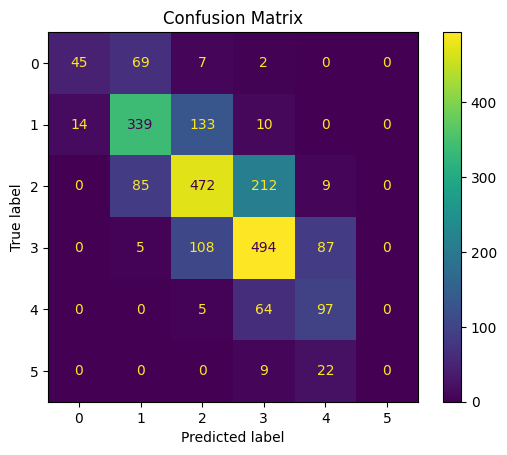

In [41]:
cm = confusion_matrix(test_data["label"], test_data["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(CFG.num_labels)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Optimal Thresholds

In [44]:
best, threshold, xs, ys = find_thresholds(test_data["label"], test_data["logit"], steps=500)

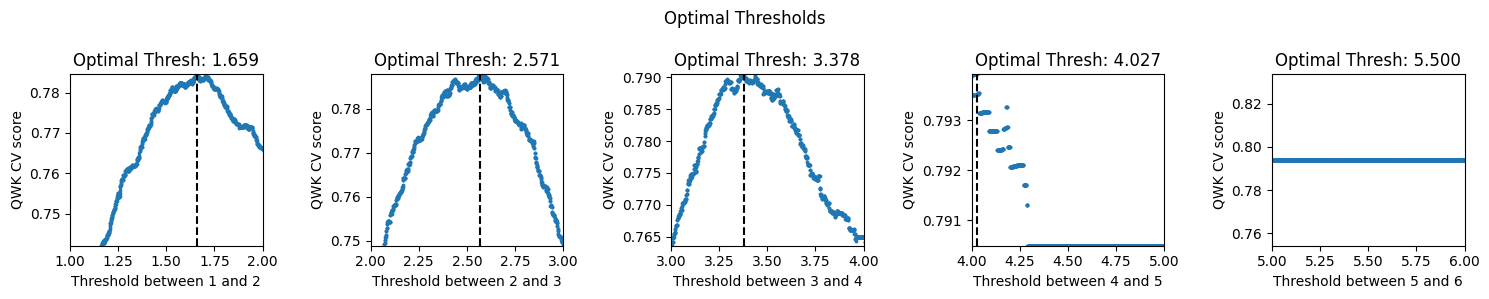

In [45]:
diff = 0.5
nrows, ncols = 1, 5  # Define grid for 5 subplots (1 row, 5 columns)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3))  # Create figure and subplots

# Loop through data and plot on each subplot
for k in range(5):
    ax = axes.flat[k]  # Access each subplot using flattened axes
    ax.scatter(xs[k], ys[k], s=3)
    m = k + 1.5
    ax.set_xlim((m - diff, m + diff))
    i = np.where((np.array(xs[k]) > m - diff) & (np.array(xs[k]) < m + diff))[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    ax.set_ylim((mn, mx))

    ax.plot(
        [threshold[k], threshold[k]],
        [mn, mx],
        "--",
        color="black",
        label="optimal threshold",
    )

    ax.set_title(f"Optimal Thresh: {threshold[k]:4.3f}", size=12)  # Adjust title size
    ax.set_xlabel(f"Threshold between {k+1} and {k+2}", size=10)
    ax.set_ylabel("QWK CV score", size=10)

# Common legend for all subplots
plt.suptitle("Optimal Thresholds", size=12)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [46]:
with open(Paths.threshold_path, "wb") as file:
    pkl.dump(threshold, file)

### QWK Score After optimal Thresholding

In [47]:
def raw_to_class(pred, threshold):
    return pd.cut(
        pred,
        [-np.inf] + threshold + [np.inf],
        labels=range(CFG.num_labels),
    ).astype(pd.Int32Dtype())

In [50]:
test_data["pred_score"] = raw_to_class(test_data["logit"], threshold)
score = compute_metrics((test_data["pred_score"], test_data["label"]))["qwk"]
print(f"Test dataset QWK score after thresholding: {score}")
# wandb.log({"CV/qwk_score_after_threshold": score})

Test dataset QWK score after thresholding: 0.5815414367293685


## Wrapping up

In [ ]:
wandb.finish()